# Agentic RAG with semantic search and Claude

This notebook demonstrates how to implement agentic retrieval-augmented generation (RAG) using multiple tools to retrieve data from both a web search and semantic search over a Pinecone index. We will cover the following steps:

1. Setup: Setup and set Pinecone and Anthropic API keys
2. Ingestion: Embedding and upserting data into Pinecone using integrated inference
3. Tool setup: Setup of the web search tool and single-step tool use for retrieval
4. Agentic workflow: Adding a second tool for semantic search over a Pinecone index for multi-tool, multi-turn chat workflows
5. Clean up: Clean up and delete your index

This notebook accompanies this [Retrieval-Augmented Generation article](https://www.pinecone.io/learn/retrieval-augmented-generation/).

## 1. Setup
First, let's install the necessary libraries and set the API keys we will need to use in this notebook.

In [1]:
%pip install -qU \
     anthropic==0.54.0 \
     pinecone==7.0.2 \
     pinecone-notebooks==0.1.1 \
     duckduckgo-search \
     datasets==3.6.0 \
     backoff==2.2.1

Note: you may need to restart the kernel to use updated packages.


### Get and set the Pinecone API key

We will need a free [Pinecone API key](https://docs.pinecone.io/guides/get-started/quickstart). The code below will either authenticate you and set the API key as an environment variable or will prompt you to enter the API key and then set it in the environment.

In [2]:
import os
from getpass import getpass

def get_pinecone_api_key():
    """
    Get Pinecone API key from environment variable or prompt user for input.
    Returns the API key as a string.

    Only necessary for notebooks. When using Pinecone yourself, 
    you can use environment variables or the like to set your API key.
    """
    api_key = os.environ.get("PINECONE_API_KEY")
    
    if api_key is None:
        try:
            # Try Colab authentication if available
            from pinecone_notebooks.colab import Authenticate
            Authenticate()
            # If successful, key will now be in environment
            api_key = os.environ.get("PINECONE_API_KEY")
        except ImportError:
            # If not in Colab or authentication fails, prompt user for API key
            print("Pinecone API key not found in environment.")
            api_key = getpass("Please enter your Pinecone API key: ")
            # Save to environment for future use in session
            os.environ["PINECONE_API_KEY"] = api_key
            print("Pinecone API key saved to environment.")
            
    return api_key

PINECONE_API_KEY = get_pinecone_api_key()

Pinecone API key not found in environment.
Pinecone API key saved to environment.


### Set the Anthropic API key

Next, we'll need to get a [Claude API key](https://docs.anthropic.com/en/api/overview). The code below will prompt you to enter it and then set it in the environment.

In [3]:
def get_anthropic_api_key():
    """
    Get Anthropic API key from environment variable or prompt user for input.
    Returns the API key as a string.
    """

    api_key = os.environ.get("ANTHROPIC_API_KEY")
    
    if api_key is None:
        print("Anthropic API key not found in environment.")
        try:
            api_key = getpass("Please enter your Anthropic API key: ")
            # Save to environment for future use in session
            os.environ["ANTHROPIC_API_KEY"] = api_key
            print("Anthropic API key saved to environment.")
        except Exception as e:
            print(f"Error getting Anthropic API key: {e}")
            return None
    
    return api_key

ANTHROPIC_API_KEY = get_anthropic_api_key()

Anthropic API key not found in environment.
Anthropic API key saved to environment.


## 2. Ingestion

### Load the dataset

In this example, we'll show you how to build an agentic RAG workflow over a set of Arxiv paper abstracts.

In [4]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2", split="train")

#Let's take a peek at the data
dataset[0]

/Users/jenna/Development/playground/notebook-playground/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'id': '2401.04088',
 'title': 'Mixtral of Experts',
 'summary': 'We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.\nMixtral has the same architecture as Mistral 7B, with the difference that each\nlayer is composed of 8 feedforward blocks (i.e. experts). For every token, at\neach layer, a router network selects two experts to process the current state\nand combine their outputs. Even though each token only sees two experts, the\nselected experts can be different at each timestep. As a result, each token has\naccess to 47B parameters, but only uses 13B active parameters during inference.\nMixtral was trained with a context size of 32k tokens and it outperforms or\nmatches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,\nMixtral vastly outperforms Llama 2 70B on mathematics, code generation, and\nmultilingual benchmarks. We also provide a model fine-tuned to follow\ninstructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,\nC

### Preprocess the dataset

We'll need to reorient our dataset to the records format, to support using Pinecone Integrated Inference. We only need some of the columns and we want the summary column renamed to chunk_text.

In [5]:
dataset = dataset.remove_columns(["content", "comment", "journal_ref", "references"])
dataset = dataset.rename_column("summary", "chunk_text")

dataset=dataset.to_list()
dataset[0]

{'id': '2401.04088',
 'title': 'Mixtral of Experts',
 'chunk_text': 'We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.\nMixtral has the same architecture as Mistral 7B, with the difference that each\nlayer is composed of 8 feedforward blocks (i.e. experts). For every token, at\neach layer, a router network selects two experts to process the current state\nand combine their outputs. Even though each token only sees two experts, the\nselected experts can be different at each timestep. As a result, each token has\naccess to 47B parameters, but only uses 13B active parameters during inference.\nMixtral was trained with a context size of 32k tokens and it outperforms or\nmatches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,\nMixtral vastly outperforms Llama 2 70B on mathematics, code generation, and\nmultilingual benchmarks. We also provide a model fine-tuned to follow\ninstructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,

### Pinecone vector database and integrated inference

We'll implement one of our retrieval tools using semantic search, but first we need to create a Pinecone index and upsert vectors into it.

We'll use integrated inference, so when creating the indexes, we'll specify a Pinecone-hosted model to use for embedding queries and documents. Pinecone handles the embedding for us, so we can pass it text directly. When we search, we'll use integrated reranking to return the most relevant matches.

Learn more about:
- Semantic search [here](https://docs.pinecone.io/guides/search/semantic-search)
- Integrated inference [here](https://docs.pinecone.io/guides/index-data/indexing-overview#integrated-embedding)
- Integrated reranking [here](https://docs.pinecone.io/guides/search/rerank-results#integrated-reranking)

Now, we can initialize the dense index, using the `llama-text-embed-v2` embedding model.

In [6]:
from pinecone import Pinecone

pc = Pinecone(
    api_key=PINECONE_API_KEY,
    # You can remove this parameter for your own projects
    source_tag="pinecone_examples:learn:generation:agentic_rag:agentic_rag_with_claude"
)

index_name = "agentic-rag-with-claude"
if not pc.has_index(index_name):
    pc.create_index_for_model(
        name=index_name,
        cloud="aws",
        region="us-east-1",
        # Chunk text will be the field we embed from our documents
        embed={
            "model":"llama-text-embed-v2",
            "field_map":{"text": "chunk_text"}
        }
    )

index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

We should see that the new Pinecone index has a total_vector_count of 0, as we haven't added any vectors yet.

Now, whenever we upsert to or query an index, Pinecone will automatically embed the text data with the specified embedding model.

To learn generally how dense models are trained and why, check out our guide [here](https://www.pinecone.io/learn/the-practitioners-guide-to-e5/).

### Embedding and upserting data to Pinecone 

With our index set up, we can now take our data and upsert them to the index. Here is a useful upsertion script that handles rate limits nicely. We [upsert in batches of 96](https://docs.pinecone.io/guides/index-data/upsert-data#upsert-in-batches), because this is the batch size limit for hosted models on Pinecone. This should take about a minute to upsert all of our data:

In [7]:
from tqdm import tqdm
import backoff

batch_size = 96

@backoff.on_exception(backoff.expo, Exception, max_tries=8, max_time=80, on_backoff=lambda details: print(f"Backoff: {details['tries']} of 8"))
def upsert_in_batches(dataset, index, batch_size):
    for start in tqdm(range(0, len(dataset), batch_size), desc="Upserting records batch"):
        batch = dataset[start:start + batch_size]
        index.upsert_records(namespace="arxiv", records=batch)

upsert_in_batches(dataset, index, batch_size)

Upserting records batch: 100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


In [8]:
print("index stats:")
index.describe_index_stats()

index stats:


{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'arxiv': {'vector_count': 2673}},
 'total_vector_count': 2673,
 'vector_type': 'dense'}

## 3. Tool setup

### Tool concepts

#### Tools

RAG gives LLMs the capability to ground their responses in data retrieved from an external data source like a Pinecone vector database.

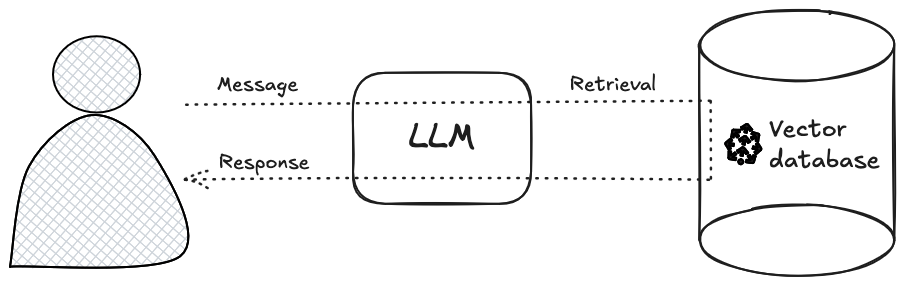

Tool use extends/generalizes this concept. A tool can be considered any service that an LLM can communicate with (eg: a search engine, a SQL database, a service like Notion, a python interpreter, etc.). An LLM can be connected to one or more tools.

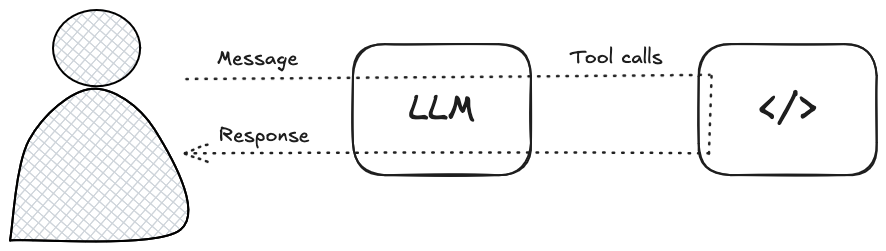

#### Decision making

With tool use, the LLM acts as decision-making engine. It has to decide:
1. Whether a user query can be answered directly or requires some external context from a tool
2. If tools are required, which tools would those be, and how to call them.

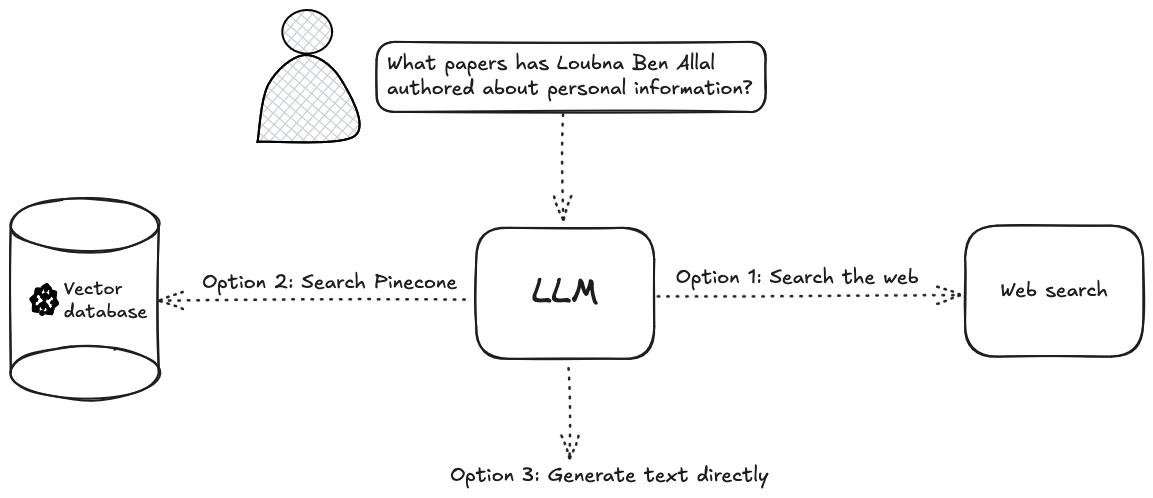

#### Actions

While RAG is a read-only setup, tool use enables developers to build applications that can take actions (i.e read and write to external systems via APIs).

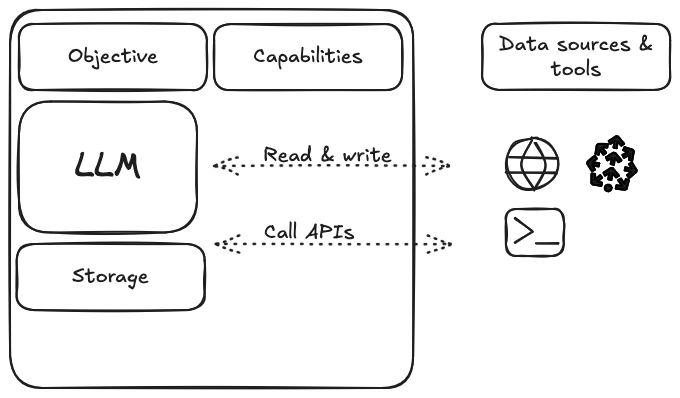

#### Function calling

If tool use is the "what" of LLM capability extension, function calling is the "how". Function calling is a specific implementation of tool use, focusing on the technical details of picking the tools to call and generating the payload to call the tool.

### Setup 

We'll setup two tools for retrieval: a web search tool and a semantic search tool.

While Anthropic does have a built in web search tool, we'll use the Duckduckgo search engine for demonstration purposes. A tool can be any function or service that can receive and send data - an email service, an SQL database, a vector database, a weather data service, or even another LLM.

In [ ]:
from duckduckgo_search import DDGS

# Tool 1: Web search engine
def web_search_engine(query: str) -> dict:
    
    search_results = DDGS().text(query, max_results=5)

    return search_results

In [10]:
web_search_engine("Papers by researcher Loubna Ben Allal")

[{'title': 'LOUBNA BEN ALLAL - Google Scholar',
  'href': 'https://scholar.google.com/citations?user=reU1i-sAAAAJ',
  'body': '\u202aHugging Face\u202c - \u202a\u202aCited by 4,518\u202c\u202c - \u202aMachine Learning\u202c'},
 {'title': 'Loubna Ben allal | Papers With Code',
  'href': 'https://paperswithcode.com/author/loubna-ben-allal',
  'body': 'The BigCode Project Governance Card no code implementations • 6 Dec 2023 • BigCode collaboration, Sean Hughes, Harm de Vries, Jennifer Robinson, Carlos Muñoz Ferrandis, Loubna Ben allal, Leandro von Werra, Jennifer Ding, Sebastien Paquet, Yacine Jernite This document serves as an overview of the different mechanisms and areas of governance in the BigCode project.'},
 {'title': '[2406.17557] The FineWeb Datasets: Decanting the Web for the Finest ...',
  'href': 'https://arxiv.org/abs/2406.17557',
  'body': 'The FineWeb Datasets: Decanting the Web for the Finest Text Data at Scale Guilherme Penedo, Hynek Kydlíček, Loubna Ben allal, Anton Lozh

In [11]:
# map tool names to functions
functions_map = {
    "web_search_engine": web_search_engine,
}

### Define the Tool Schema

The schema is what will be passed to the Anthropic API when running a tool use workflow. The schema informs the LLM about what the tool does, and the LLM decides whether to use a particular tool based on it. Therefore, the more descriptive and specific the schema, the more likely the LLM will make the right tool call decisions.

In [12]:
web_search_engine_tool = {
    "name": "web_search_engine",
    "description": "Searches the internet and retrieves content relevant to the input query",
    "input_schema": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": "The search query."
            }
        },
        "required": ["query"]
    }
}

tools = [
  web_search_engine_tool
]

### Review tool_use response

Let's check out the response from Claude when it decides a tool should be used. Note the tool use block that indicates which tool function we should call and what the function parameters are.

In [13]:
query = "What papers has Loubna Ben Allal written?"

In [14]:
import anthropic

client = anthropic.Anthropic()
model = "claude-3-5-haiku-latest"
messages = []

messages.append({
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": f"{query}"
        }
    ]
})

response = client.messages.create(
    model=model,
    max_tokens=1000,
    temperature=1,
    tools=tools,
    messages=messages
)

print(response)

Message(id='msg_01D87dkaiFSbkVPpYWbDJ2tH', content=[ToolUseBlock(id='toolu_014MUwZz4wFRRkU1zq9hXKPJ', input={'query': 'Loubna Ben Allal research papers published'}, name='web_search_engine', type='tool_use')], model='claude-3-5-haiku-20241022', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=355, output_tokens=65, server_tool_use=None, service_tier='standard'))


### Invoke the tool and send tool_result back to Claude

Here we invoke the tool, append the tool_result user block and send it back to Claude. The LLM will reason over the tool results to generate a response for the user.

In [15]:
# Add assistant tool use back to the messages context
messages.append({
    "role": "assistant",
    "content": response.content
})

tool_result = functions_map[response.content[0].name](
    **response.content[0].input
)

print("TOOL_RESULT:")
print(tool_result)

tool_content = []
tool_result_items = []

for data in tool_result:
    tool_result_items.append({
        "type": "text",
        "text": data
    })

tool_content.append(
    {
        "type": "tool_result",
        "tool_use_id": response.content[0].id,
        "content": str(tool_result_items),
    }
)
messages.append(
    {
        "role": "user",
        "content": tool_content,
    }
)

print("SENT MESSAGES")
print(messages)

response = client.messages.create(
    model=model,
    max_tokens=1000,
    temperature=1,
    tools=tools,
    messages=messages
)
print("RESPONSE:")
print(response)

TOOL_RESULT:
[{'title': 'LOUBNA BEN ALLAL - Google Scholar', 'href': 'https://scholar.google.com/citations?user=reU1i-sAAAAJ', 'body': '\u202aHugging Face\u202c - \u202a\u202aCited by 4,518\u202c\u202c - \u202aMachine Learning\u202c'}, {'title': 'Loubna Ben allal | Papers With Code', 'href': 'https://paperswithcode.com/author/loubna-ben-allal', 'body': 'The BigCode Project Governance Card no code implementations • 6 Dec 2023 • BigCode collaboration, Sean Hughes, Harm de Vries, Jennifer Robinson, Carlos Muñoz Ferrandis, Loubna Ben allal, Leandro von Werra, Jennifer Ding, Sebastien Paquet, Yacine Jernite This document serves as an overview of the different mechanisms and areas of governance in the BigCode project.'}, {'title': 'Loubna Ben Allal - Home - ACM Digital Library', 'href': 'https://dl.acm.org/profile/99661625996', 'body': "Colleague Collaboration Author's Latest Publications research-article Scaling laws and compute-optimal training beyond fixed training durations Alexander Häg

The response we get here may be the final response or model may want us to call the same tool again or another tool. If we need to call the same or another tool, we'll need to wrap this in a while loop until a final response is returned. We'll do this and define a second tool in the next section.

## Agentic Workflow

In an agentic workflow, the LLM can manage multiple tools in a multi-turn chat scenario.

### Setup second tool

First, we'll define a new tool to do a semantic search over a Pinecone index.

In [16]:
# Tool 2: Vector Search
def pinecone_vector_search(query: str) -> list[dict]:
    # search_records embeds and queries the Pinecone index and reranks results in one step
    results = index.search(
        namespace="arxiv", 
        query={
            # specifies number of results to return
            "top_k":10,
            # specifies the query to embed and search for
            "inputs":{
                "text": query
            }
        },
        rerank={
            "model": "bge-reranker-v2-m3",
            # reranks the top_k results and returns the top_n
            "top_n": 5,
            "rank_fields": ["chunk_text"]
        },
    )

    return results["result"]["hits"]

functions_map = {
    "web_search_engine": web_search_engine,
    "pinecone_vector_search": pinecone_vector_search,
}

pinecone_vector_search_tool = {
    "name": "pinecone_vector_search",
    "description": "Searches Pinecone vector database dense index to retrieve documents relevant to the input query. The index contains arxiv papers.",
    "input_schema": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": "The search query."
            }
        },
        "required": ["query"]
    }
}

tools = [
    web_search_engine_tool, 
    pinecone_vector_search_tool,
]

### Define the agentic workflow

This workflow we defined is looped over to handle multiple tools.

In [17]:
import anthropic
import json

client = anthropic.Anthropic()
model = "claude-3-5-haiku-latest"

def run_agent(query, messages=None, verbose_source=False):
    
    if messages is None:
        messages = []
        
    # Step 1: get user message
    print(f"QUESTION:\n{query}")
    print("=" * 50)
    messages.append({"role": "user", "content": query})
    
    # Step 2: Generate tool calls (if any)
    response = client.messages.create(
        model=model,
        max_tokens=1000,
        temperature=1,
        tools=tools,
        messages=messages
    )

    print("INITIAL RESPONSE:")
    print(response)
    
    while response.stop_reason == "tool_use":
        print("TOOL CALLS:")
        print(response.content)        

        # Add assistant tool use back to the messages context
        messages.append({
            "role": "assistant",
            "content": response.content
        })
        
        # Step 3: Invoke each tool
        for tc in response.content:
            if tc.type == "tool_use":
                print(  
                    f"Tool name: {tc.name} | Parameters: {tc.input}"
                )
                print("=" * 50)
                # Call the tool with input
                tool_result = functions_map[tc.name](
                    **tc.input
                )

                # print("TOOL_RESULT")
                # print(tool_result)

                tool_content = []
                tool_result_items = []

                for data in tool_result:
                    tool_result_items.append({
                        "type": "text",
                        "text": data
                    })

                tool_content.append(
                    {
                        "type": "tool_result",
                        "tool_use_id": tc.id,
                        "content": str(tool_result_items),
                    }
                )
                messages.append(
                    {
                        "role": "user",
                        "content": tool_content,
                    }
                )
            else:
                print(f'Not a tool_use content block: {tc}')
   
        # Step 4: Generate response
        print("calling step 4 with:")
        print(messages)
        response = client.messages.create(
            model=model,
            max_tokens=1000,
            temperature=1,
            tools=tools,
            messages=messages
        )
        print("RESPONSE:")
        print(response)
        
    messages.append(
        {
            "role": "assistant",
            "content": response.content[0].text,
        }
    )
    
    # Print final response
    print("FINAL RESPONSE:")
    print(response.content[0].text)
    print("=" * 50)
            
    return messages

In [18]:
messages = run_agent("What papers are about personal information?", messages=[])

QUESTION:
What papers are about personal information?
INITIAL RESPONSE:
Message(id='msg_01PA9ZbFAfa2sv1NimWgBgrK', content=[TextBlock(citations=None, text="I'll search for relevant academic papers about personal information using the Pinecone vector search.", type='text'), ToolUseBlock(id='toolu_01QtZPpAzu66MD5cTB7LKAiN', input={'query': 'personal information privacy research papers'}, name='pinecone_vector_search', type='tool_use')], model='claude-3-5-haiku-20241022', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=434, output_tokens=81, server_tool_use=None, service_tier='standard'))
TOOL CALLS:
[TextBlock(citations=None, text="I'll search for relevant academic papers about personal information using the Pinecone vector search.", type='text'), ToolUseBlock(id='toolu_01QtZPpAzu66MD5cTB7LKAiN', input={'query': 'personal information privacy research papers'}, name='pinecone_v

In [19]:
# multi-turn conversation - sometimes this will use both tools, too
messages = run_agent("Are any of these written by Loubna Ben Allal?", messages=messages)

QUESTION:
Are any of these written by Loubna Ben Allal?
INITIAL RESPONSE:
Message(id='msg_01CLXHz1hxMtznAomZRUhCEG', content=[TextBlock(citations=None, text="I'll search to check if Loubna Ben Allal is an author on any of these papers.", type='text'), ToolUseBlock(id='toolu_01SifprLfnGMkZtYAEeKvQxH', input={'query': 'Loubna Ben Allal author personal information papers'}, name='web_search_engine', type='tool_use')], model='claude-3-5-haiku-20241022', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=4096, output_tokens=90, server_tool_use=None, service_tier='standard'))
TOOL CALLS:
[TextBlock(citations=None, text="I'll search to check if Loubna Ben Allal is an author on any of these papers.", type='text'), ToolUseBlock(id='toolu_01SifprLfnGMkZtYAEeKvQxH', input={'query': 'Loubna Ben Allal author personal information papers'}, name='web_search_engine', type='tool_use')]
Not a to

### Multi-step tool use

In Multi-step tool use, the LLM engages in "planning" to determine what tools need to be called and the sequence in which they will be called, to answer the user query. This enables the capability for the LLM to autonomously perform complex tasks using a Thought-Action-Observation reasoning series.

Compared to the single-step tool use, in multi-step tool use the output of the initial tool is an input to the subsequent tools.

In [20]:
# Multi-step tool use
messages = run_agent("What papers has Loubna Ben Allal authored about personal information?", messages=[])

QUESTION:
What papers has Loubna Ben Allal authored about personal information
INITIAL RESPONSE:
Message(id='msg_015M3SogetiX3q8FfnWDKuLj', content=[TextBlock(citations=None, text="Let me search for information about Loubna Ben Allal's research papers related to personal information.", type='text'), ToolUseBlock(id='toolu_012JvzM4CSnwhZzqfg7FzDUp', input={'query': 'Loubna Ben Allal papers on personal information privacy research'}, name='web_search_engine', type='tool_use')], model='claude-3-5-haiku-20241022', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=442, output_tokens=91, server_tool_use=None, service_tier='standard'))
TOOL CALLS:
[TextBlock(citations=None, text="Let me search for information about Loubna Ben Allal's research papers related to personal information.", type='text'), ToolUseBlock(id='toolu_012JvzM4CSnwhZzqfg7FzDUp', input={'query': 'Loubna Ben Allal pap

## Cleanup Indexes

Run these when you're done experimenting, to delete the index.

In [70]:
pc.delete_index(name=index_name)
